# Building Electricity Consumption Assesment

#### Brief overview:

The energy demand for each cell is assessed according to the following parameters:
𝐵 Number of buildings
𝑆𝑟𝑒𝑠 Share of res buildings
𝑁 Nb of HH per res buildings
𝑎 Electrified status (probability)
𝐸_𝐻𝐻  Energy consumption per HH
𝑟 Adjustment with RWI

For each cell c, we have 𝐷_𝑐=𝐵_𝑐∗𝑆𝑟𝑒𝑠∗𝑁_𝑐  ∗𝑎_𝑐  ∗𝐸_𝐻𝐻  ∗𝑟_𝑐 

### Import necessary modules

In [1]:
# Check if we are running the notebook directly, if so move workspace to parent dir
import sys
import os
currentdir = os.path.abspath(os.getcwd())
if os.path.basename(currentdir) != 'EDeMOS':  
  sys.path.insert(0, os.path.dirname(currentdir))
  os.chdir('..')
  print(f'Move to {os.getcwd()}')

Move to C:\Users\amillot\PycharmProjects\EDeMOS


In [2]:
### Activate geospatial_env first

# Numeric
import numpy as np
import pandas as pd
import math
from scipy.optimize import fsolve

# Spatial
import geopandas as gpd

import importlib
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

In [3]:
pd.options.display.float_format = '{:,.2f}'.format

In [4]:
import config
importlib.reload(config)

INFO: Successfully loaded configuration for Zambia from config.py.
INFO: Successfully loaded configuration for Zambia from config.py.


<module 'config' from 'C:\\Users\\amillot\\PycharmProjects\\EDeMOS\\config.py'>

In [5]:
import plotting

In [6]:
from utils import processing_raster, finalizing_rasters, convert_features_to_geodataframe

In [7]:
import Buildings.data_loader
importlib.reload(Buildings.data_loader)
from Buildings.data_loader import load_initial_data, extract_raster_data, load_un_stats, load_census_data, load_rwi_data, extract_pop_raster_data, clean_nan_location_wp

In [8]:
import Buildings.residential_hh_analysis
importlib.reload(Buildings.residential_hh_analysis)
from Buildings.residential_hh_analysis import determine_location_status, determine_electrification_status, calculate_household_numbers, estimate_hh_with_access, calculate_household_numbers_popinput
import Buildings.residential_analysis
importlib.reload(Buildings.residential_analysis)
from Buildings.residential_analysis import calculate_energy_per_hh_method1, calculate_total_residential_electricity,compare_access_to_falchetta

In [9]:
import Buildings.figures_input_data
importlib.reload(Buildings.figures_input_data)
from Buildings.figures_input_data import *
from plotting import plot_sector_consumption_map

In [10]:
try: extracting_data
except NameError: extracting_data = False
extracting_data

False

## Import data

### Load initial data grid

In [11]:
# Load initial data (grid and administrative boundaries)
regions, admin_gdf, region_gdf, grid = load_initial_data(config)
print(grid.crs)

Loading initial data...
Admin boundaries loaded. Country GDF: (1, 3), Region GDF: (10, 12)
Hexagon grid loaded: (122901, 10)
Validating that all regions have cells in the pre-processed grid...
Validation successful: All target regions are present in the grid file.
EPSG:4326


### Extract GIS values to hexagons

In [12]:
# Extract GIS data
if extracting_data:
    grid = extract_raster_data(grid, config, processing_raster, convert_features_to_geodataframe)
    # grid = load_rwi_data(grid, config)
    grid.to_file(config.RESIDENTIAL_TEMP_FILE, layer="buildings", driver="GPKG", mode='w')
    print(grid.crs)

In [13]:
# Extract GIS data
if extracting_data:
    grid = load_rwi_data(grid, config)
    grid.to_file(config.RESIDENTIAL_TEMP_FILE, layer="buildings", driver="GPKG", mode='w')

In [14]:
if extracting_data and config.USE_POP_FILE:
    grid = extract_pop_raster_data(grid, config, processing_raster, convert_features_to_geodataframe)
    grid.to_file(config.RESIDENTIAL_TEMP_FILE, layer="buildings", driver="GPKG", mode='w')

In [15]:
if not extracting_data:
    grid = gpd.read_file(config.RESIDENTIAL_TEMP_FILE)

### Extract residential and service demand from UN stats

In [16]:
total_residential_elec_GWh, total_services_elec_GWh = load_un_stats(config)

Loading UN energy balance statistics...
Total Residential electricity (UN Stats): 4022 GWh
Total Services electricity (UN Stats): 722 GWh


### Load Census data

In [17]:
data_HH, df_censusdata = load_census_data(config)

Loading census data...
Provincial census data loaded: (11, 11)


## Residential electricity consumption assessment

Plotting buildings map...


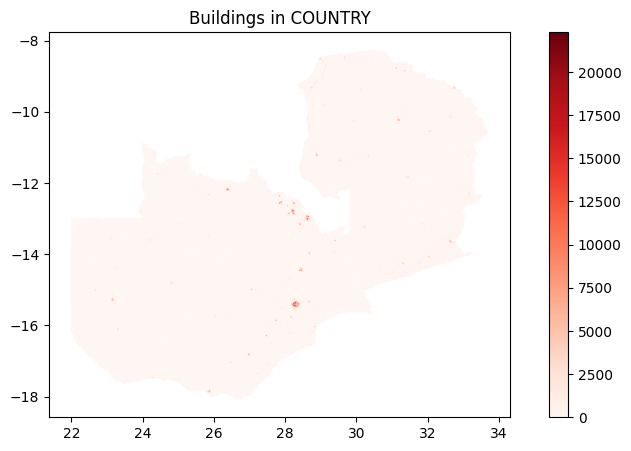

In [18]:
plot_buildings_map(grid, config, fig_size=(10, 5))

In [19]:
print(f"Total number of buildings: {grid[config.COL_BUILDINGS_SUM].sum():.0f}")

Total number of buildings: 8922145


Plotting HREA map...


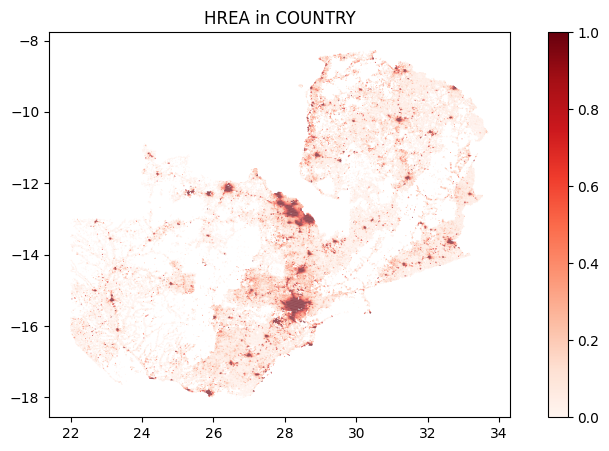

In [20]:
plot_hrea_map(grid, config, fig_size=(10, 5))

### Step 1: assess the number of HH with access

#### Determine location (ruban or rural) of each cell

In [21]:
grid = clean_nan_location_wp(grid, config)
grid = determine_location_status(grid, config)

NaN values filled using nearest neighbor.
0
Determining location status (urban/rural)...
'location' column created. Counts: {'rural': 122216, 'urban': 685}


Plotting Urban/Rural map...


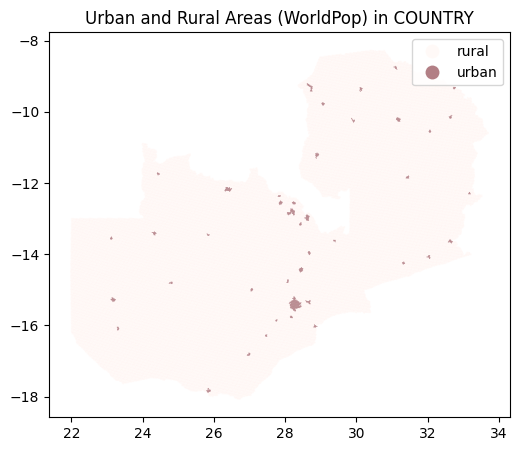

In [22]:
plot_urban_rural_map(grid, config, fig_size=(10, 5))

#### Determine electrifed status of each cell

In [23]:
grid = determine_electrification_status(grid, config, admin_gdf)

Determining electrification status...
--- Initial Data Sanity Check ---
Grid CRS: EPSG:4326 | Shape: (122901, 19)
Admin Boundary CRS: EPSG:4326 | Shape: (1, 3)
MV Lines CRS: EPSG:4326 | Shape: (64868, 49)
HV Lines CRS: EPSG:4326 | Shape: (931, 63)
Target CRS for all operations: EPSG:32735

--- Projecting all data to target CRS ---
Processing proximity for HV Lines with buffer 500m...
Processing proximity for MV Lines with buffer 500m...
Updated 'is_near_any_line' column. Current counts:
is_near_any_line
False    112043
True      10858
Name: count, dtype: int64
'status_electrified' column created. Counts: {'nonelec': 118702, 'elec': 4199}


Plotting Line Proximity map...


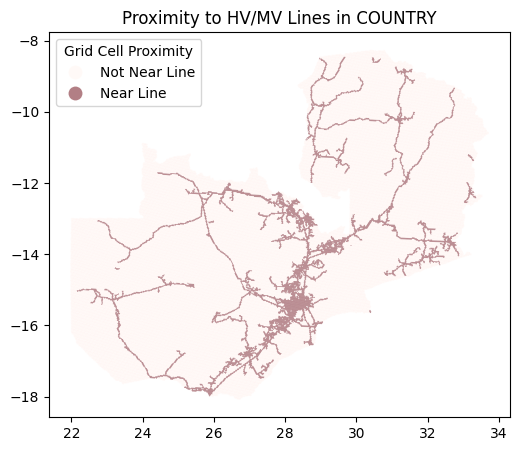

In [24]:
plot_line_proximity_map(grid, config, admin_gdf, fig_size=(10, 5))

#### Assess number of households per cell

In [25]:
if config.USE_POP_FILE:
    grid = calculate_household_numbers_popinput(grid_gdf, app_config, data_HH, df_censusdata)
else:
    grid, df_HH_buildings = calculate_household_numbers(grid, config, data_HH, regions)

Calculating household numbers...
Total population calculated: 17,798,700
Finished calculating household numbers.


In [26]:
if not config.USE_POP_FILE:
    print(df_HH_buildings.head(3))

                HH_urban   HH_rural  size_HH_urban  size_HH_rural   HH_total  \
region                                                                         
Copperbelt    449,077.00  85,356.00           4.66           5.13 534,433.00   
Muchinga       24,953.00 151,730.00           4.30           4.73 176,683.00   
North-Western  91,501.00 116,233.00           5.03           5.53 207,734.00   

               totalBuildings  urbanBuildings  ruralBuildings  \
region                                                          
Copperbelt       1,013,514.90      556,480.38      457,034.52   
Muchinga           558,966.21       72,558.00      486,408.21   
North-Western      510,596.69      138,291.26      372,305.43   

               shareRuralBuild  shareUrbanBuild  shareUrbanResBui  \
region                                                              
Copperbelt                0.45             0.55              0.73   
Muchinga                  0.87             0.13              0.31 

#### Assess number of households per cell with access to electricity

In [27]:
grid, df_HH_buildings = estimate_hh_with_access(grid, config, df_HH_buildings, data_HH)

Estimating households with access...
Aggregating HH and population access data by region...
Total population with access (estimated): 6,658,978
Regional HH summary saved to C:\Users\amillot\PycharmProjects\EDeMOS\Buildings\Outputs\dataHH_region.csv
         accessRateHH accessRateHH_urban accessRateHH_rural
Central          0.27               0.71               0.12
Southern         0.30               0.74               0.14
Eastern          0.20               0.68               0.09
Lusaka           0.68               0.75               0.37
National         0.39               0.72               0.15
National Summary Access Rates:
accessRateHH          0.39
accessRateHH_urban    0.72
accessRateHH_rural    0.15
accessRatePop         0.37
accessRatePop_urban   0.72
accessRatePop_rural   0.15
Name: National, dtype: object
Finished estimating households with access.


### Step 2: assess the electricity consumption per HH

#### Method 1: link the energy consumption to rwi through a logistic function

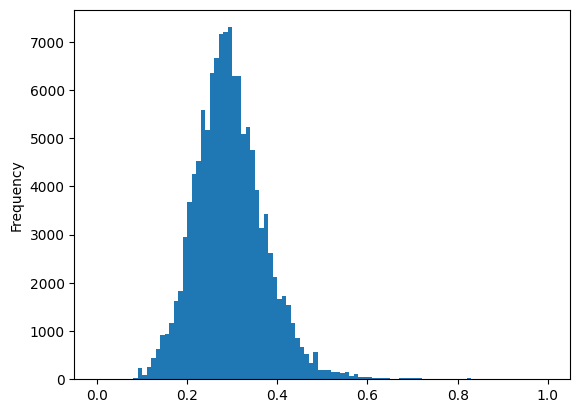

In [28]:
# Normalise the rwi index
rwi_min = grid[config.COL_RWI_MEAN].min()
rwi_max = grid[config.COL_RWI_MEAN].max()
grid[config.COL_RWI_NORM] = (grid[config.COL_RWI_MEAN] - rwi_min) / (rwi_max - rwi_min)
grid[config.COL_RWI_NORM].plot.hist(bins=100)
plt.show()

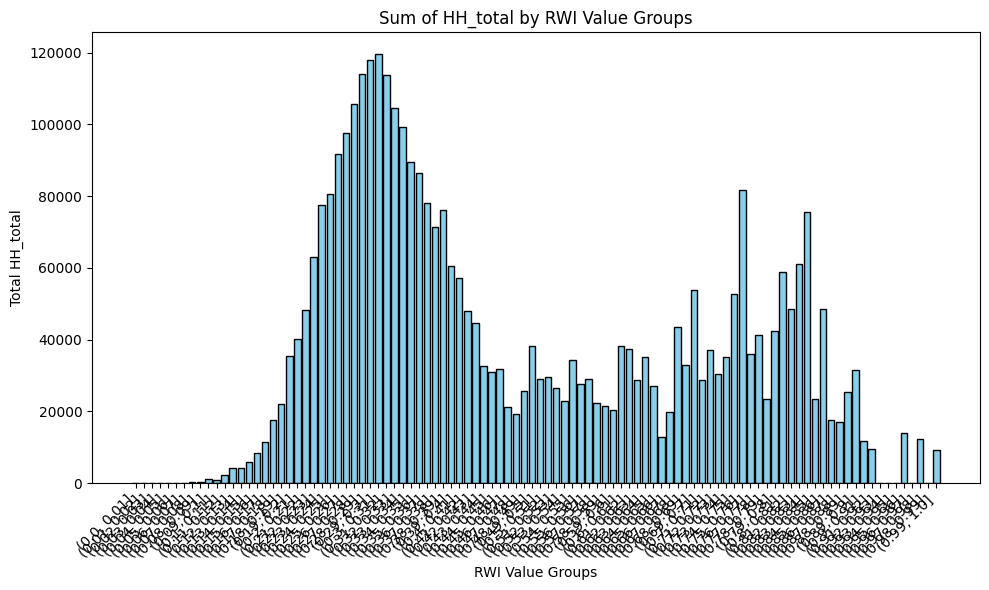

In [29]:
# Plot of number of HH vs rwi

# Create equally spaced bins for the 'rwi' values
num_groups = 100
min_rwi = grid[config.COL_RWI_NORM].min()
max_rwi = grid[config.COL_RWI_NORM].max()
bin_width = (max_rwi - min_rwi) / num_groups
rwi_bins = [min_rwi + i * bin_width for i in range(num_groups + 1)]
rwi_bins_labels = [(rwi_bins[i] + rwi_bins[i])/2 for i in range(num_groups)]

# Group by the bins and sum the 'HH_total' values
grid['rwi_group'] = pd.cut(grid[config.COL_RWI_NORM], rwi_bins)
result = grid.groupby('rwi_group')[config.COL_HH_TOTAL].sum()
result.index = result.index.astype(str)
# # Print the result
# print(result)

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(result.index, result.values, color='skyblue', edgecolor='black')
# plt.bar(rwi_bins_labels, result.values, color='skyblue', edgecolor='black')
plt.xlabel('RWI Value Groups')
plt.ylabel('Total HH_total')
plt.title('Sum of HH_total by RWI Value Groups')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

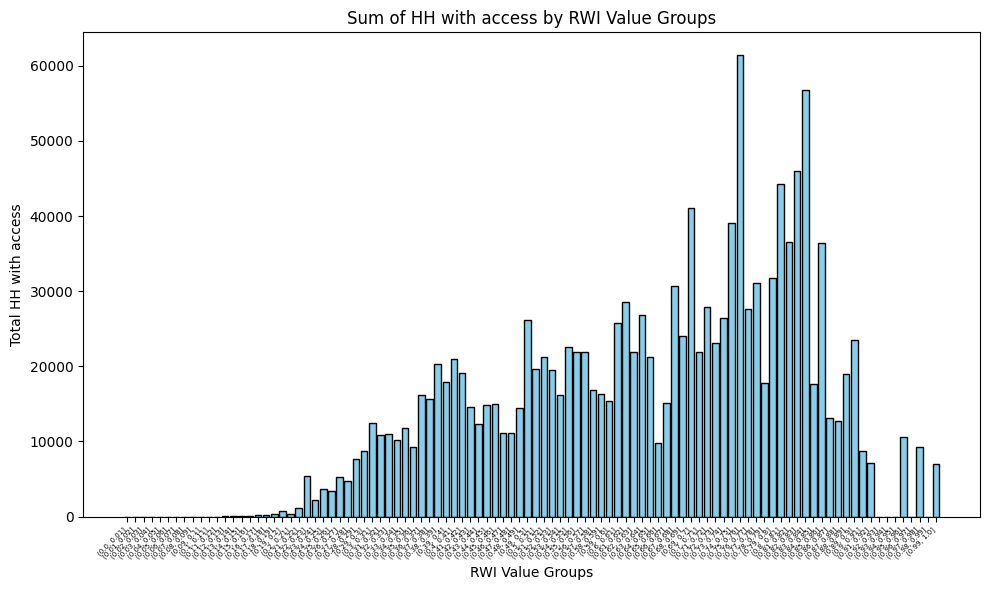

In [30]:
# Plot of number of HH with access vs rwi

# Group by the bins and sum the 'HHwithAccess' values
result = grid.groupby('rwi_group')[config.COL_HH_WITH_ACCESS].sum()
result.index = result.index.astype(str)
# # Print the result
# print(result)

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.rc('xtick', labelsize=5)
plt.bar(result.index, result.values, color='skyblue', edgecolor='black')
plt.xlabel('RWI Value Groups')
plt.ylabel('Total HH with access')
plt.title('Sum of HH with access by RWI Value Groups')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [31]:
grid, k_to_use = calculate_energy_per_hh_method1(grid, config, total_residential_elec_GWh)

Calculating energy per HH (Method 1: RWI-logistic)...
Solved k for logistic function: 17.7945
Finished calculating energy per HH (Method 1).


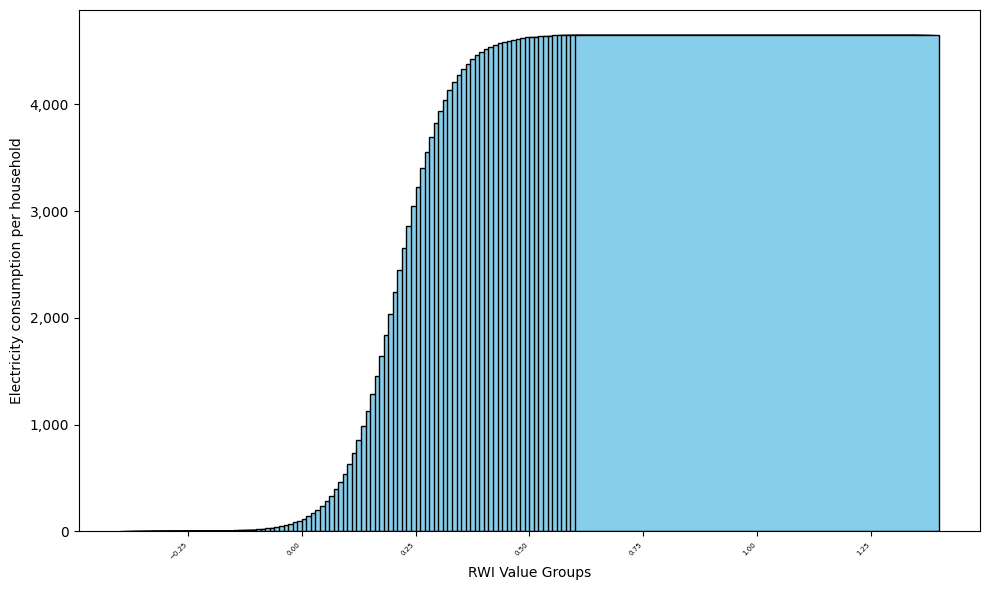

In [32]:
# create the curve linking energy consumption per HH and rwi
rwi_values = rwi_bins # rwi value groups
k = k_to_use  # Adjust this constant for the desired curve steepness
E_threshold = config.LOGISTIC_E_THRESHOLD
alpha = config.LOGISTIC_E_THRESHOLD / config.LOGISTIC_ALPHA_DERIVATION_THRESHOLD - 1
E_HH_values = config.LOGISTIC_E_THRESHOLD / (1 + alpha * np.exp(-k * np.array(rwi_values)))
# print(E_threshold / (1 + alpha * np.exp(-k  * 0)))
# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(rwi_values, E_HH_values, color='skyblue', edgecolor='black')
plt.xlabel('RWI Value Groups')
plt.ylabel('Electricity consumption per household')
ax = plt.gca()  # Get the current axis
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
# plt.title('Energy vs. RWI with logistic relationship')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

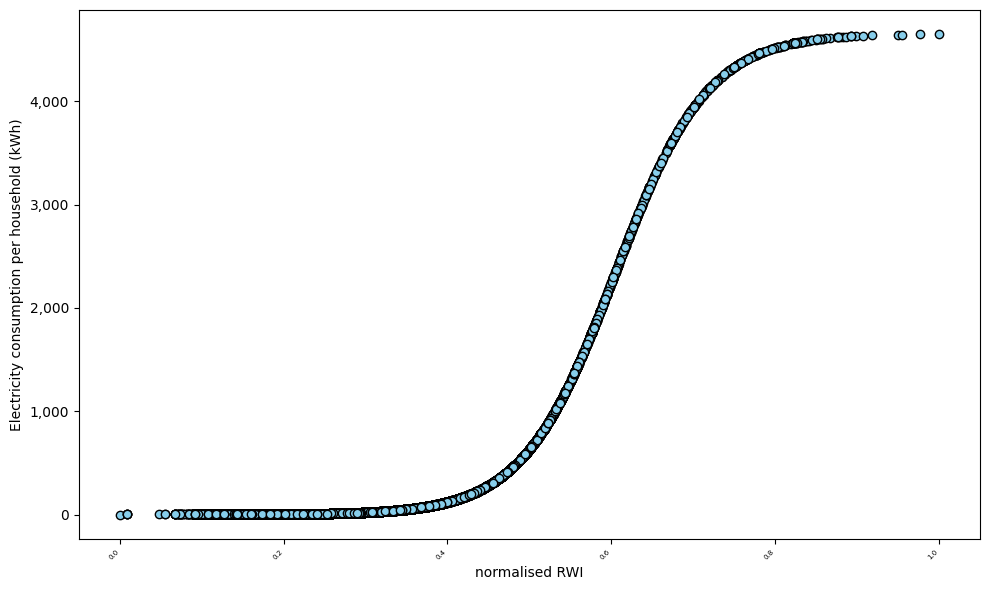

In [33]:
# check that total energy assessed matches the statistics
grid[config.COL_RES_ELEC_PER_HH_LOG] = E_threshold / (1 + alpha * np.exp(-k * grid[config.COL_RWI_NORM]))

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.scatter(grid[config.COL_RWI_NORM], grid[config.COL_RES_ELEC_PER_HH_LOG], color='skyblue', edgecolor='black')
plt.xlabel('normalised RWI')
plt.ylabel('Electricity consumption per household (kWh)')
ax = plt.gca()  # Get the current axis
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
# plt.title('Energy vs. RWI with Logarithmic Relationship')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Method 2: use data coming from the DHS survey

Read data on 12831 survey households
Estimating average energy use per household...
Tier 1 (Electricity,Mobile telephone,Radio) = 11.4 kWh/y
Tier 2 (Television) = 294.8 kWh/y
Tier 3 (Microwave,Washing machine,Computer) = 691.8 kWh/y
Tier 4 (Refrigerator) = 2,258.2 kWh/y
Tier 5 (Air conditioner) = 6,055.1 kWh/y

Applying flexible override rules to adjust tiers...
Updated 598 households to Tier 5 based on rule: 'Has car/truck' is 'yes'
Updated 3 households to Tier 4 based on rule: 'Source of drinking water' is 'bottled water'
Updated 63 households to Tier 4 based on rule: 'Source of drinking water' is 'piped into dwelling'
Updated 104 households to Tier 3 based on rule: 'Type of toilet facility' is 'flush to septic tank'
Updated 70 households to Tier 3 based on rule: 'Type of toilet facility' is 'flush to piped sewer system'
Updated 22 households to Tier 3 based on rule: 'Has motorcycle/scooter' is 'yes'
Written energy use estimates to C:\Users\amillot\PycharmProjects\EDeMOS\Buildings\Da

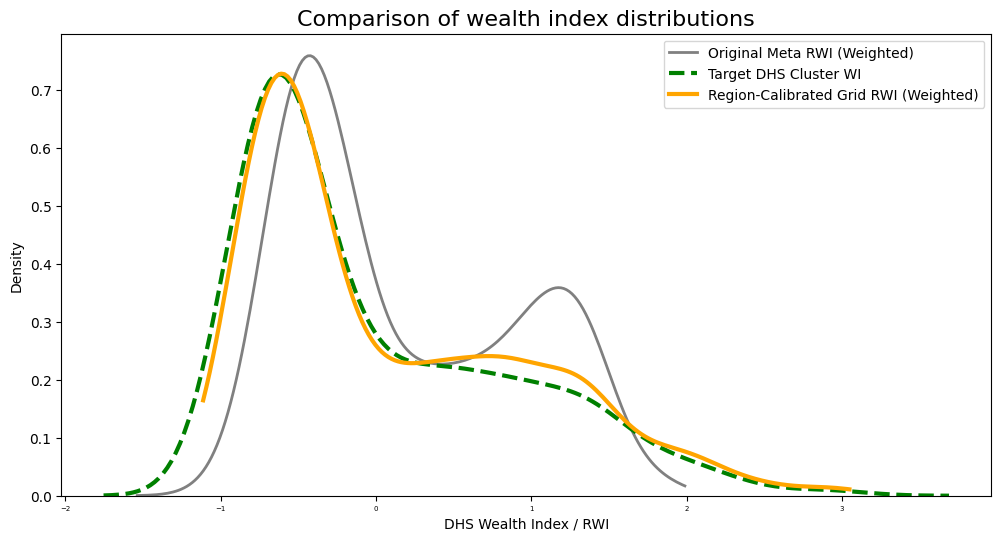


--- 4. Training Models and Predicting Consumption ---
--- Processing Urban Subset ---
--- Processing Rural Subset ---

--- 5. Final Results ---
Prediction complete. Total predicted consumption for the country: 2,802.23 GWh
  - Urban: 2,281.60 GWh
  - Rural: 520.63 GWh


In [34]:
import Buildings.HouseholdEnergyUse.dhs_electricity_rwi_link_estimate
importlib.reload(Buildings.HouseholdEnergyUse.dhs_electricity_rwi_link_estimate)
from Buildings.HouseholdEnergyUse.dhs_electricity_rwi_link_estimate import estimate_electricity_rwi_link

grid = estimate_electricity_rwi_link(grid, config)   

### Step 3: assess electricity consumption per cell

In [35]:
grid = calculate_total_residential_electricity(grid, config, total_residential_elec_GWh)

Calculating total residential energy and scaling...
Method meth1: Total Assessed = 4022.50 GWh, UN Stats = 4022.50 GWh, Scaling Factor = 1.0000
Method meth2: Total Assessed = 2802.23 GWh, UN Stats = 4022.50 GWh, Scaling Factor = 1.4355

Summary of energy consumption before scaling (GWh):
                 meth1  meth2
NAME_1                       
Central         195.99 223.34
Copperbelt    1,312.12 704.94
Eastern         163.03 175.37
Luapula          57.37 141.55
Lusaka        1,507.06 925.51
Muchinga         25.82  31.16
North-Western   153.88 128.16
Northern        145.03 105.59
Southern        358.64 268.94
Western         103.58  97.69

Summary of energy consumption after scaling (GWh):
                 meth1    meth2
NAME_1                         
Central         195.99   320.59
Copperbelt    1,312.12 1,011.91
Eastern         163.03   251.74
Luapula          57.37   203.19
Lusaka        1,507.06 1,328.54
Muchinga         25.82    44.72
North-Western   153.88   183.96
Northern   

In [36]:
# Analysis HH with access
metrics_grid = grid.groupby(config.COL_LOC_ASSESSED).agg(
    # --- Components for the Weighted Average ---
    # 1. Sum of TOTAL electricity consumption for each group
    total_elec_kwh=(config.COL_RES_TOTAL_ELEC_KWH_DHS, 'sum'),
    
    # 2. Sum of TOTAL households with access for each group
    total_hh_with_access=(config.COL_HH_WITH_ACCESS, 'sum'),

    # Range of elec_kWh (min and max)
    min_elec_kWh=(config.COL_RES_ELEC_PER_HH_KWH_DHS, 'min'),
    max_elec_kWh=(config.COL_RES_ELEC_PER_HH_KWH_DHS, 'max'),
    
    # Average consumption
    average_elec_kWh=(config.COL_RES_ELEC_PER_HH_KWH_DHS, 'mean'),
    
    # Range of rwi (min and max)
    min_rwi=(config.COL_RWI_ANALYSIS, 'min'),
    max_rwi=(config.COL_RWI_ANALYSIS, 'max')
)
metrics_grid['weighted_avg_elec_kWh'] = metrics_grid['total_elec_kwh'] / metrics_grid['total_hh_with_access']

print("\n--- Calculated Metrics for Urban and Rural Areas ---")
print(metrics_grid)



--- Calculated Metrics for Urban and Rural Areas ---
           total_elec_kwh  total_hh_with_access  min_elec_kWh  max_elec_kWh  \
location                                                                      
rural      520,626,112.60            312,823.33          0.00      2,687.68   
urban    2,281,604,880.59          1,120,254.48        975.52      3,609.21   

          average_elec_kWh  min_rwi  max_rwi  weighted_avg_elec_kWh  
location                                                             
rural               126.53    -1.02     1.97               1,664.28  
urban             1,597.42    -0.94     2.96               2,036.68  


In [37]:
# Analysis Total HH
metrics_grid_total = grid.groupby(config.COL_LOC_ASSESSED).agg(
    # --- Components for the Weighted Average ---
    # 1. Sum of TOTAL electricity consumption for each group
    total_elec_kwh=(config.COL_RES_TOTAL_ELEC_KWH_DHS, 'sum'),
    
    # 2. Sum of TOTAL households with access for each group
    total_hh=(config.COL_HH_TOTAL, 'sum'),

    # Range of elec_kWh (min and max)
    min_elec_kWh=(config.COL_RES_ELEC_PER_HH_KWH_DHS, 'min'),
    max_elec_kWh=(config.COL_RES_ELEC_PER_HH_KWH_DHS, 'max'),
    
    # Average consumption
    average_elec_kWh=(config.COL_RES_ELEC_PER_HH_KWH_DHS, 'mean'),
    
    # Range of rwi (min and max)
    min_rwi=(config.COL_RWI_ANALYSIS, 'min'),
    max_rwi=(config.COL_RWI_ANALYSIS, 'max')
)
metrics_grid_total['weighted_avg_elec_kWh'] = metrics_grid_total['total_elec_kwh'] / metrics_grid_total['total_hh']

print("\n--- Calculated Metrics for Urban and Rural Areas ---")
print(metrics_grid_total)


--- Calculated Metrics for Urban and Rural Areas ---
           total_elec_kwh     total_hh  min_elec_kWh  max_elec_kWh  \
location                                                             
rural      520,626,112.60 2,104,898.00          0.00      2,687.68   
urban    2,281,604,880.59 1,562,390.00        975.52      3,609.21   

          average_elec_kWh  min_rwi  max_rwi  weighted_avg_elec_kWh  
location                                                             
rural               126.53    -1.02     1.97                 247.34  
urban             1,597.42    -0.94     2.96               1,460.33  


### Compare access rates to Falchetta dataset

In [38]:
grid = compare_access_to_falchetta(grid, config)

Comparing access tiers to Falchetta dataset...

Falchetta Tiers Summary (tiers_falchetta_maj):
                     national  urban  rural
tiers_falchetta_maj                        
0.00                     0.56   0.05   0.93
1.00                     0.00   0.00   0.00
2.00                     0.01   0.01   0.01
3.00                     0.01   0.02   0.01
4.00                     0.42   0.92   0.04

Falchetta Tiers Summary (tiers_falchetta_mean):
                      national  urban  rural
tiers_falchetta_mean                        
0                         0.51   0.01   0.87
1                         0.04   0.02   0.05
2                         0.04   0.05   0.03
3                         0.05   0.09   0.03
4                         0.37   0.83   0.02

Tier Shares for Method 'meth1':
             national  urban  rural
tiers_meth1                        
0                0.61   0.28   0.86
1                0.03   0.01   0.04
2                0.04   0.04   0.04
3                0.0

### Final grid

In [39]:
grid[config.COL_RES_ELEC_KWH_FINAL]=grid[config.COL_RES_ELEC_KWH_METH2_SCALED]

In [40]:
grid.to_csv(config.RESIDENTIAL_GRID_FILE)

In [41]:
# Convert categorical columns to strings
for col in grid.select_dtypes(include=['category']).columns:
    #print(col)
    grid[col] = grid[col].astype(str)

In [42]:
if 'rwi_group' in grid.columns:
    grid = grid.drop('rwi_group', axis=1)
if 'tiers_DHS' in grid.columns:
    grid = grid.drop('tiers_DHS', axis=1)
if 'bin_labels' in grid.columns:
    grid = grid.drop('bin_labels', axis=1)
grid.to_file(config.RESIDENTIAL_OUTPUT_DIR / f'res_energy_map_{config.COUNTRY}.shp', index=False)
grid.head(3)

,h3_index,n0,n1,n2,n3,n4,n5,NAME_1,id,buildingssum,...,res_elec_kWh_meth1,res_elec_kWh_meth1_scaled,res_elec_kWh_meth2,res_elec_kWh_meth2_scaled,tiers_meth1,tiers_meth2,tiers_DHS_adjusted,Similarity_Falchetta_DHS,Difference_Falchetta_DHS,res_elec_kWh_final
0,8796ac271ffffff,87032,102525,"55,537.00","5,742.00","63,337.00","71,225.00",Northern,1,6.00,...,0.00,0.00,0.00,0.00,1,0,0,True,0.00,0.00
1,879613118ffffff,58309,118163,"33,987.00","24,994.00","39,743.00","68,098.00",Northern,2,43.73,...,0.00,0.00,0.00,0.00,1,0,0,True,0.00,0.00
2,879752006ffffff,120705,76632,"22,377.00","34,828.00",789.00,"9,815.00",Southern,3,0.00,...,0.00,0.00,0.00,0.00,2,3,3,False,3.00,0.00


### Map residential results

Plotting Residential Consumption map...


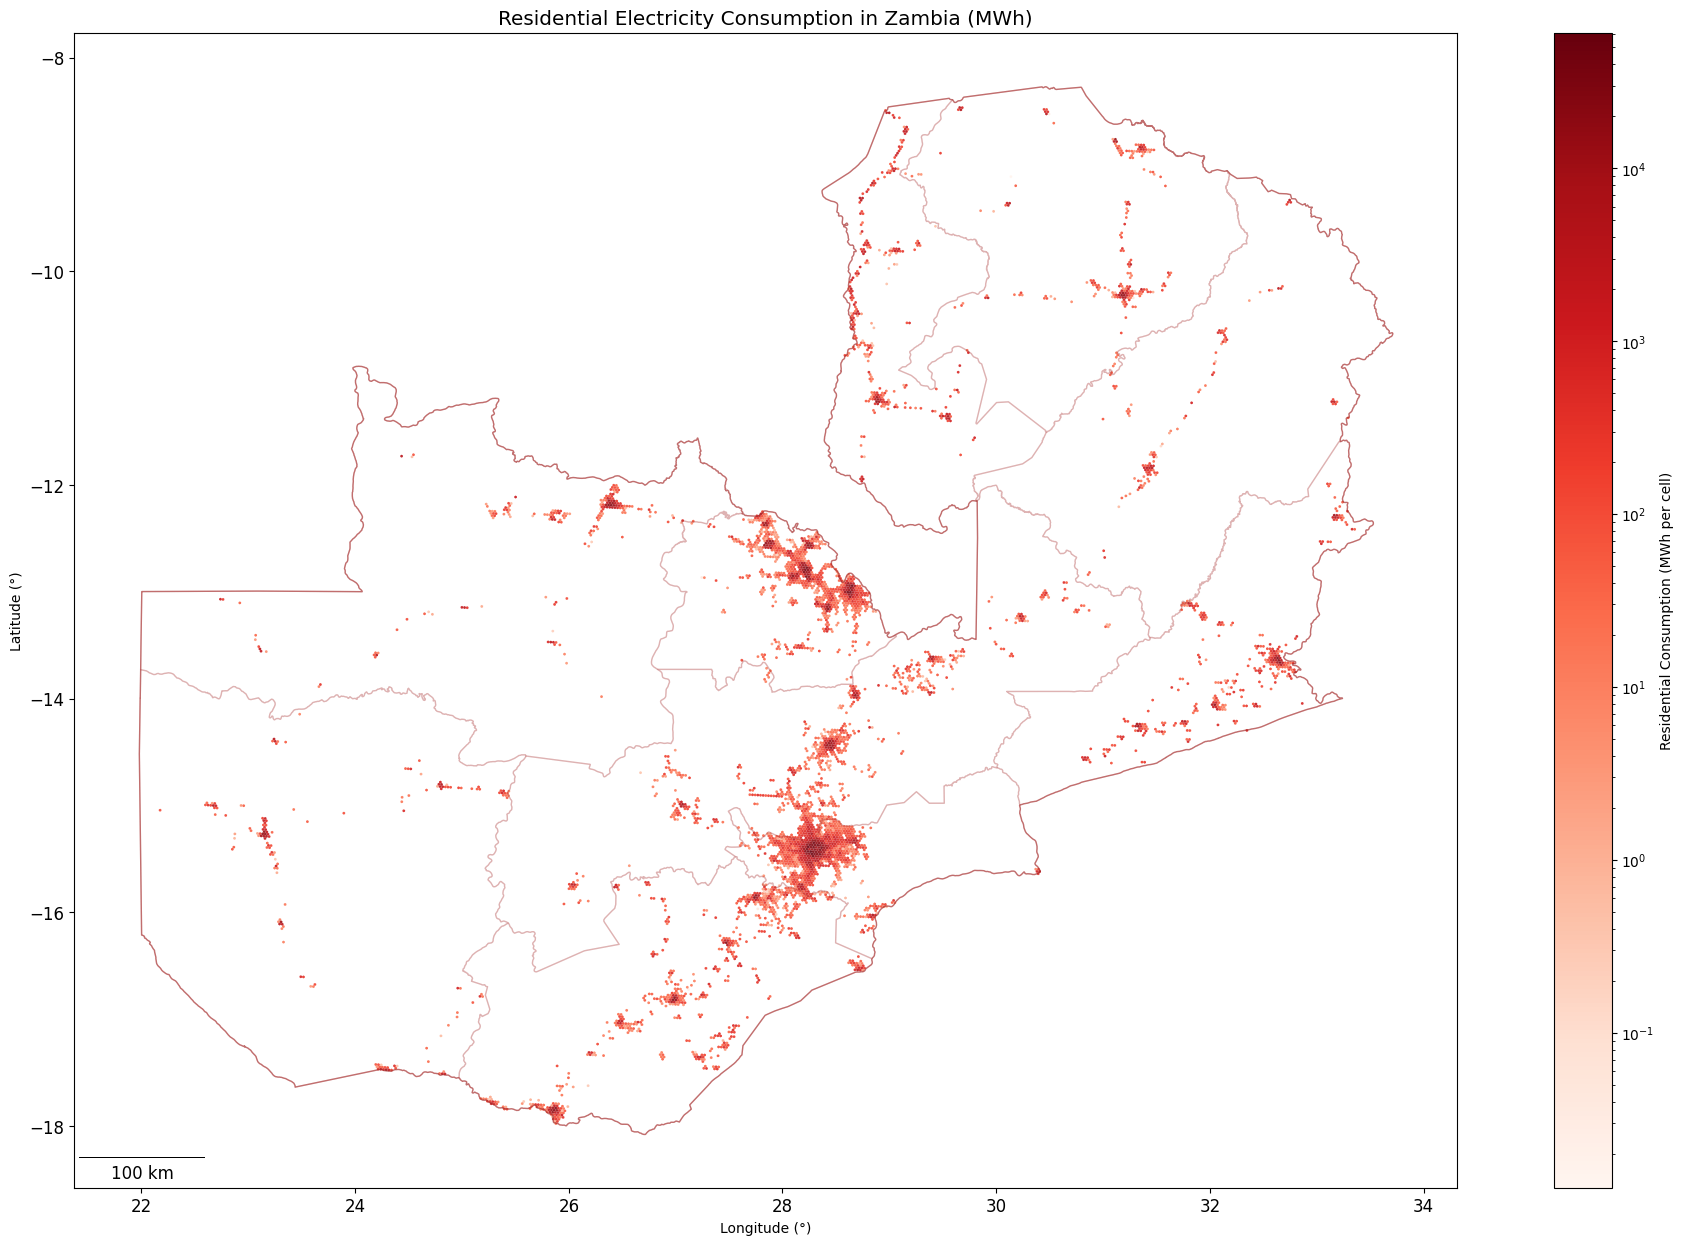

In [43]:
plot_sector_consumption_map(grid, config.COL_RES_ELEC_KWH_METH2_SCALED, config, admin_gdf, region_gdf, 'Residential', fig_size=(25, 15))

# Services

In [44]:
import Buildings.service_analysis
importlib.reload(Buildings.service_analysis)
from Buildings.service_analysis import calculate_service_buildings_based_elec, calculate_service_gdp_based_elec, calculate_employee_based_electricity

## Electricity consumption based on number of buildings with access

In [45]:
grid = calculate_service_buildings_based_elec(grid, config, total_services_elec_GWh)

Calculating services electricity (building-based)...
Total services buildings with estimated access: 1,918,367
Service electricity per accessible building: 376 kWh/building
Finished calculating services electricity (building-based).


## Energy consumption based on GDP

In [46]:
# grid = calculate_service_gdp_based_elec(grid, config, total_services_elec_GWh)

## Energy consumption based on employees

In [47]:
grid = calculate_employee_based_electricity(grid, config, total_services_elec_GWh, df_censusdata)

Calculating services energy (employee-based)...
  Calculating number of men and women (15-49)...
  Calculating number of working men and women...
Total employees with access: 1,936,500
Service electricity per accessible employee: 372.67 kWh/employee
Finished calculating services energy (employee-based).


## Weighted average of the three assessements

In [48]:
# if config.COL_GDP_PPP_MEAN in grid.columns:
#     # Link between buildings and GDP
#     plt.scatter(grid['serBUi_Acc'], grid['GDP_PPP'],s=1)
    
#     # Add labels to the plot
#     plt.xlabel('serBUi_Acc')
#     plt.ylabel('GDP_PPP')
    
#     # Set the axis to logarithmic scale
#     # plt.yscale('log')
#     # plt.xscale('log')
    
#     # Show the plot
#     plt.show()

In [49]:
threshold_access = 0.1 # lower value than residential because easier to connect services buildings
alpha = config.SERVICES_WEIGHT_GDP
beta = config.SERVICES_WEIGHT_BUILDINGS
gama = config.SERVICES_WEIGHT_EMPLOYEES

In [50]:
# compute weighted average
grid['SElec_kWh_weighted'] = (beta * grid[config.COL_SER_ELEC_KWH_BUI] + gama * grid[config.COL_SER_ELEC_KWH_EMP] )
totalSEn_kWh_weighted = grid['SElec_kWh_weighted'].sum()
grid[config.COL_SER_ELEC_KWH_FINAL] = grid['SElec_kWh_weighted'] / totalSEn_kWh_weighted * total_services_elec_GWh *10**6 

## Results per region and map

In [51]:
services_result = pd.DataFrame()
services_result = grid.groupby(config.COL_ADMIN_NAME)[config.COL_SER_ELEC_KWH_FINAL].sum() / 10**6 # conversion in GWh
pd.options.display.float_format = '{:.2f}'.format
services_result

NAME_1
Central          52.16
Copperbelt      201.32
Eastern          42.00
Luapula          24.78
Lusaka          241.49
Muchinga          6.91
North-Western    36.83
Northern         25.22
Southern         65.27
Western          25.69
Name: ser_elec_kWh_final, dtype: float64

Plotting Services Consumption map...


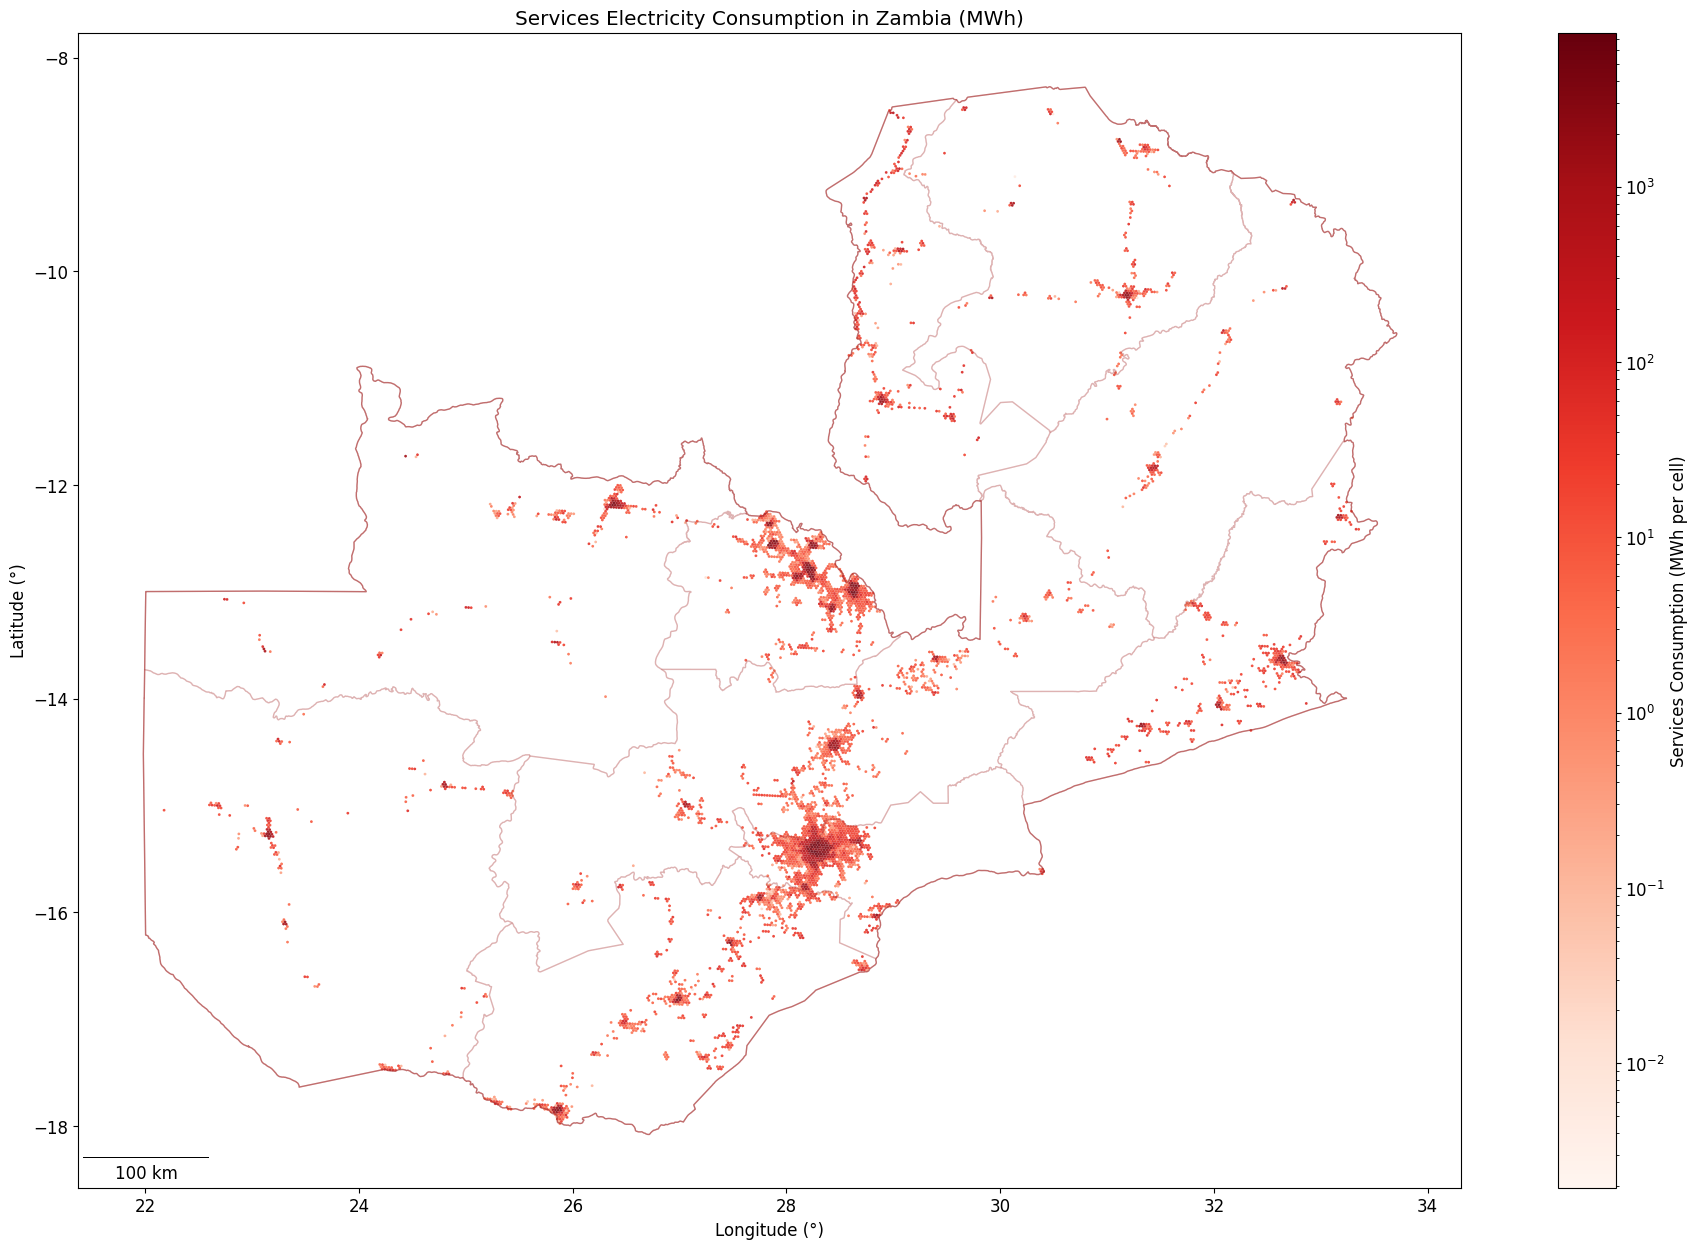

In [52]:
plot_sector_consumption_map(grid, config.COL_SER_ELEC_KWH_FINAL, config, admin_gdf, region_gdf, 'Services', fig_size=(25, 15))

In [53]:
grid.to_csv(config.SERVICES_GRID_FILE)
# grid.to_file(config.RESIDENTIAL_OUTPUT_DIR / f'ser_energy_map_{config.COUNTRY}.shp', index=False)
# grid.to_file(config.RESIDENTIAL_OUTPUT_DIR /  f'ser_energy_map_{config.COUNTRY}.geojson', driver='GeoJSON', index=False)
grid.to_file(config.BUILDINGS_GPKG_FILE, layer="buildings", driver="GPKG", mode='w')
grid.head(3)

,h3_index,n0,n1,n2,n3,n4,n5,NAME_1,id,buildingssum,...,ser_elec_kWh_bui,nb_women,nb_men,nb_women_working,nb_men_working,total_employee,total_employee_withaccess,ser_elec_kWh_emp,SElec_kWh_weighted,ser_elec_kWh_final
0,8796ac271ffffff,87032,102525,55537.00,5742.00,63337.00,71225.00,Northern,1,6.00,...,236.84,2.24,2.06,0.30,0.37,0.66,0.00,0.00,0.00,0.00
1,879613118ffffff,58309,118163,33987.00,24994.00,39743.00,68098.00,Northern,2,43.73,...,537.94,16.33,15.04,2.18,2.66,4.84,0.00,0.00,0.00,0.00
2,879752006ffffff,120705,76632,22377.00,34828.00,789.00,9815.00,Southern,3,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [54]:
total_services_elec_scaled_kwh = grid.groupby(config.COL_ADMIN_NAME)[config.COL_SER_ELEC_KWH_FINAL].sum()
# Reindex the result using your master list of regions.
#    This ensures every region has an entry. Missing ones will be filled with NaN.
total_services_elec_scaled_kwh = total_services_elec_scaled_kwh.reindex(regions)
# Conversion to GWh.
total_services_elec_scaled_gwh = total_services_elec_scaled_kwh / 10**6
print("Services electricity consumption assessed after scaling:")

for region in regions:
    value_gwh = total_services_elec_scaled_gwh[region]    
    # Check if the value is NaN before trying to format it as a number
    if pd.isna(value_gwh):
        print(f"{region}: NaN GWh")
    else:
        print(f"{region}: {value_gwh:,.0f} GWh")

Services electricity consumption assessed after scaling:
Central: 52 GWh
Copperbelt: 201 GWh
Eastern: 42 GWh
Luapula: 25 GWh
Lusaka: 241 GWh
Muchinga: 7 GWh
North-Western: 37 GWh
Northern: 25 GWh
Southern: 65 GWh
Western: 26 GWh


# Buildings

In [55]:
# total_Buienergy_scaled = total_servicesenergy_scaled + total_residentialenergy_scaled
grid[config.COL_BUI_ELEC_KWH_FINAL]=grid[config.COL_RES_ELEC_KWH_FINAL]+grid[config.COL_SER_ELEC_KWH_FINAL]
total_buildings_elec_scaled = grid.groupby(config.COL_ADMIN_NAME)[config.COL_BUI_ELEC_KWH_FINAL].sum()
total_buildings_elec_scaled = total_buildings_elec_scaled.reindex(regions)
print ("Buildings electricity consumption assessed after scaling:")
for region in regions:
    print (region, f"{total_buildings_elec_scaled[region]:,.0f}", "GWh" )

Buildings electricity consumption assessed after scaling:
Central 372,749,083 GWh
Copperbelt 1,213,234,057 GWh
Eastern 293,738,788 GWh
Luapula 227,960,865 GWh
Lusaka 1,570,021,824 GWh
Muchinga 51,637,048 GWh
North-Western 220,794,967 GWh
Northern 176,801,447 GWh
Southern 451,319,006 GWh
Western 165,909,582 GWh
